# 02052024_Teste_Versão

Validação dos modelos apresentados na reunião de 30-04-2024 (terça-feira).

os seguintes ids foram removidos do treino e não foram usados no teste tambem:

        '11015449', '2678578', '121163', '2377239', '2429267', '2512323', '3092139', '2861615',
        '8152558', '3451478', '479237', '4730437', '121034'


- Observação:
Havia dados nulos, nesse caso foi usado o mode para categoricos e mean para numericos. Caso houvesse dados numericos cujo o normalização resultou em NAN, foi introduzido 0.0 como preenchimento.

### Load dataframe

In [1]:
# Load dataframe teste
import pandas as pd

dataframe = pd.read_csv('02052024_13_evasion_teste.csv')

# Filtering data 'is_fake' and 'is_falecido':
dataframe = dataframe[(dataframe['is_fake'] == False) & (dataframe['falecido'] == False)].copy()

In [2]:
dataframe[['xp_code','ultima_transferencia','transferoutdate','data_saida_montebravo','ultimo_mes_ativo']]


,xp_code,ultima_transferencia,transferoutdate,data_saida_montebravo,ultimo_mes_ativo
0,11015449,2023-12-08,NaN,NaN,NaN
1,121163,2022-09-06,2024-04-17,NaN,NaN
2,121034,2024-03-27,NaN,NaN,NaN
3,2429267,2024-04-01,2024-04-13,NaN,NaN
4,2678578,2024-04-08,NaN,NaN,NaN
5,1001270,2023-06-01,NaN,NaN,NaN
6,2377239,2024-01-10,NaN,NaN,NaN
7,2512323,2024-01-05,NaN,NaN,NaN
8,2861615,2024-03-05,2024-04-29,NaN,NaN
9,3092139,2023-11-22,2024-04-13,NaN,NaN


In [3]:
# Deleting column - no needed anymore
dataframe.drop(columns=['is_fake','falecido','transferoutdate'], inplace=True)

### Treatment

#### Missing values

In [4]:
# How many missing data
missing = (dataframe.isna().sum().sort_values(ascending=False) / len(dataframe) ) * 100
missing[:11]

ultimo_mes_ativo                   100.000000
data_saida_montebravo              100.000000
possuiapolice                      100.000000
nps_ultima_nota                     85.714286
monthly_income                       7.142857
assessor_praca                       7.142857
patrimonio_xp_mes_aa                 0.000000
trasnferencia_ted_in_mes_aaaa        0.000000
trasnferencia_ted_in_mes_aaaaa       0.000000
trasnferencia_ted_in_mes_aaaaaa      0.000000
patrimonio_xp_mes_a                  0.000000
dtype: float64

#### 'cliente_data_nascimento' and 'ultima_transferencia' Formating

In [5]:
import datetime as dt

dataframe['cliente_data_nascimento'] = dataframe['cliente_data_nascimento'].apply(lambda x: dt.datetime.strptime(str(x), '%Y-%m-%d').date() if pd.notnull(x) else pd.NaT)
dataframe['ultima_transferencia'] = dataframe['ultima_transferencia'].apply(lambda x: dt.datetime.strptime(str(x), '%Y-%m-%d').date() if pd.notnull(x) else pd.NaT)

#### Adding 'last_transfer_days' column

In [6]:
import datetime as dt

# Adding the feature 'last_tranfer_days' - how many days took between the churn and transition?
for x in range(len(dataframe)):
    if(pd.notnull(dataframe['ultima_transferencia'].loc[x])):
        if(pd.isnull(dataframe['data_saida_montebravo'].loc[x])):
            dataframe.loc[x, 'last_tranfer_days'] = int((dt.datetime.today().date() - dataframe['ultima_transferencia'].loc[x]).days)
        else:
            dataframe.loc[x, 'last_tranfer_days'] = int((dataframe['data_saida_montebravo'].loc[x] - dataframe['ultima_transferencia'].loc[x]).days)
    else: pass

# Deleting column - no needed anymore
dataframe.drop(columns=['ultima_transferencia','data_saida_montebravo'], inplace=True)

#### Adding 'cliente_idade' column

In [7]:
# Creating bdy col
dataframe['cliente_idade'] = pd.NA

for x in range(len(dataframe)):
    if(pd.notnull(dataframe['ultimo_mes_ativo'].loc[x])): # if the cliente is desactivated, get the age he get-out.
        if(pd.notnull(dataframe['cliente_data_nascimento'].loc[x])): # if the bdy is on db...
            dataframe.loc[x, 'cliente_idade']= int((dataframe['ultimo_mes_ativo'].loc[x] - dataframe['cliente_data_nascimento'].loc[x]).days / 365.25)
        else: pass
    else: # otherwise is an active client,
        if(pd.notnull(dataframe['cliente_data_nascimento'].loc[x])): # if the bdy is on db...
            dataframe.loc[x, 'cliente_idade'] = int((dt.datetime.today().date() - dataframe['cliente_data_nascimento'].loc[x]).days / 365.25)
        else: pass
        
# Getting the clients below 100's
dataframe = dataframe[dataframe['cliente_idade'] < 99].copy()

# Deleting column - no needed anymore
dataframe.drop(columns=['cliente_data_nascimento', 'ultimo_mes_ativo'], inplace=True)

#### General formatting for categorical data and casting for numerical data

In [8]:
import string

# Extracting the first profession of all clients
dataframe['profession'] = dataframe['profession'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

dataframe['profession'] = dataframe['profession'].apply(lambda x: x.split(' ')[0].lower())
dataframe['maritial_status'] = dataframe['maritial_status'].apply(lambda x: x.split('(')[0].lower())
dataframe['nationality'] = dataframe['nationality'].apply(lambda x: x.split()[0].lower())
dataframe['cliente_qualificacao'] = dataframe['cliente_qualificacao'].apply(lambda x: x.split()[1].lower())

# changing the cliente_idade as number
dataframe['cliente_idade'] = pd.to_numeric(dataframe['cliente_idade'], downcast='float')
dataframe['last_tranfer_days'] = pd.to_numeric(dataframe['last_tranfer_days'], downcast='float')

In [9]:
dataframe['assessor_praca'] = dataframe['assessor_praca'].str.lower()
dataframe['cliente_perfil'] = dataframe['cliente_perfil'].str.lower()
dataframe['cliente_qualificacao'] = dataframe['cliente_qualificacao'].str.lower()

dataframe['gender'] = dataframe['gender'].replace({'Masculino': 'M', 'Feminino': 'F'})
dataframe['profession'].replace({
    'bancos': 'bancario',
    'nao': 'outros',
    'ensino': 'outros',
    'instituicoes': 'outros',
    'industrias': 'outros',
    'profissionais': 'outros',
    'rio': 'outros',
    'rio': 'outros',
    'selecione': 'outros',
    'sociedades': 'empresario',
    'trab': 'trabalhador',
    'empregado': 'trabalhador',
    'secretarioestenografodatilograforecepcionistatelefonista': 'outros'}, 
    inplace=True)

dataframe['maritial_status'].replace({
    'uniãƒo estãvel':'casado',
    'separado':'divociado', 
    'uniao estavel': 'casado',
    'união estável': 'casado'
}, inplace=True)

dataframe['assessor_xp_code'].replace({'0': 'A0'}, inplace=True)

In [11]:
# Here i can do mannually
boolean_column = [
    'do_allocation_structured_products',
    'do_commodities',
    'do_long_short',
    'do_model_portfolios',
    'do_options',
    'do_speculative_structured_products',
    'do_swing_trade',
    'ir_trade_user',
    'is_from_acquisition',
    'is_from_expansion',
    'is_politically_exposed'
]

binary_mapping = { True: 1.0, False: 0.0 }

for col in boolean_column: dataframe[col] = dataframe[col].map(binary_mapping)

In [12]:
# Removing any white-space
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.applymap(trim_strings)

dataframe = trim_all_columns(dataframe)

C:\Users\Wande\AppData\Local\Temp\ipykernel_6320\3429022447.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(trim_strings)


#### Filling empty data before encoding

In [13]:
dataframe.dtypes.value_counts()

float64    92
object      9
int64       8
Name: count, dtype: int64

In [14]:
# Numerical data (mean)
col_float = dataframe.select_dtypes('float64').columns.to_list()
col_int = dataframe.select_dtypes('int64').columns.to_list()
col_numeric = col_float + col_int

# Categorical data (mode)
col_object = dataframe.select_dtypes('object').columns.to_list()

In [15]:
# Getting the data with only the type needed
dataframe_numerical = dataframe[dataframe.columns.intersection(col_numeric)]
dataframe_categorical = dataframe[dataframe.columns.intersection(col_object)]

# Mean to fill the numerical dataset
mean_dt = dataframe_numerical.mean()

# Mode to fill the categorical dataset
mode_dt = dataframe_categorical.mode(dropna=True)

dataframe.set_index('xp_code', inplace=True)

for col, _ in dataframe.items():
    if(col in col_numeric):
        if(pd.isna(mean_dt[col])):
            dataframe[col] = dataframe[col].fillna(0.0)
        else:
            dataframe[col] = dataframe[col].fillna(mean_dt[col])
    elif(col in col_object):
        if(pd.isna(mode_dt[col][0])):
            dataframe[col] = dataframe[col].fillna(mean_dt[col])
        else:
            dataframe[col] = dataframe[col].fillna(mode_dt[col][0])

#### Encoding categorical data with Label Encoder & Normalizing numerical data

In [16]:
# Encoding object columns and saving the map
from collections import defaultdict
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
import joblib

with open('label_encoder_dict.joblib', 'rb') as f:
    d = joblib.load(f)
    
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = d[col].fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = d[colname].fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

dataframe_columns = dataframe.select_dtypes('object').columns.to_list()
categorical_dataframe = MultiColumnLabelEncoder(columns=dataframe_columns).fit_transform(dataframe)

In [17]:
# Normalize the historical data
class MultiColumnNormalizer:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self, X, y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                if(pd.isna(output[col].min()/output[col].max())):
                    output[col] = 0.0
                else:
                    output[col] = (output[col] - output[col].min())/(output[col].max() - output[col].min())
        else:
            for colname, col in output.iteritems():
                if(pd.isna(col.min()/col.max())):
                    output[colname] = 0.0
                else:
                    output[colname] = (col - col.min())/(col.max() - col.min())
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

numeric_columns = ['resgates_ultimos_2_meses', 'cliente_pl_declarado_ajustado',
            'diversificacao_mes_a', 'diversificacao_mes_aa', 'diversificacao_mes_aaa', 'diversificacao_mes_aaaa', 'diversificacao_mes_aaaaa', 
            'diversificacao_mes_aaaaaa', 'pl_total_maximo', 'pl_total_mes_atual',
            'pl_total_mes_a', 'pl_total_mes_aa', 'pl_total_mes_aaa', 'pl_total_mes_aaaa', 'pl_total_mes_aaaaa', 'pl_total_mes_aaaaaa',
            'rentabilidade_mes_a', 'rentabilidade_mes_aa', 'rentabilidade_mes_aaa', 'rentabilidade_mes_aaaa', 'rentabilidade_mes_aaaaa', 'rentabilidade_mes_aaaaaa', 
            'valor_cartao_mes_a', 'valor_cartao_mes_aa', 'valor_cartao_mes_aaa', 'valor_cartao_mes_aaaa', 'valor_cartao_mes_aaaaa', 'valor_cartao_mes_aaaaaa', 
            'trasnferencia_total_out_mes_a', 'trasnferencia_total_out_mes_aa', 'trasnferencia_total_out_mes_aaa', 'trasnferencia_total_out_mes_aaaa',  
            'trasnferencia_total_out_mes_aaaaa', 'trasnferencia_total_out_mes_aaaaaa',
            'trasnferencia_total_in_mes_a', 'trasnferencia_total_in_mes_aa', 'trasnferencia_total_in_mes_aaa', 'trasnferencia_total_in_mes_aaaa', 
            'trasnferencia_total_in_mes_aaaaa', 'trasnferencia_total_in_mes_aaaaaa', 
            'receita_renda_fixa_mes_a', 'receita_renda_fixa_mes_aa', 'receita_renda_fixa_mes_aaa',  'receita_renda_fixa_mes_aaaa', 
            'receita_renda_fixa_mes_aaaaa', 'receita_renda_fixa_mes_aaaaaa', 
            'receita_total_geral_mes_a', 'receita_total_geral_mes_aa', 'receita_total_geral_mes_aaa', 'receita_total_geral_mes_aaaa', 
            'receita_total_geral_mes_aaaaa', 'receita_total_geral_mes_aaaaaa',
            'trasnferencia_ted_out_mes_a', 'trasnferencia_ted_out_mes_aa', 'trasnferencia_ted_out_mes_aaa', 'trasnferencia_ted_out_mes_aaaa', 
            'trasnferencia_ted_out_mes_aaaaa', 'trasnferencia_ted_out_mes_aaaaaa', 
            'trasnferencia_ted_in_mes_a', 'trasnferencia_ted_in_mes_aa', 'trasnferencia_ted_in_mes_aaa', 'trasnferencia_ted_in_mes_aaaa', 
            'trasnferencia_ted_in_mes_aaaaa', 'trasnferencia_ted_in_mes_aaaaaa',
            'patrimonio_xp_mes_a', 'patrimonio_xp_mes_aa', 'patrimonio_xp_mes_aaa', 'patrimonio_xp_mes_aaaa', 'patrimonio_xp_mes_aaaaa', 
            'patrimonio_xp_mes_aaaaaa', 
            'saldo_disponivel_mes_a', 'saldo_disponivel_mes_aa', 'saldo_disponivel_mes_aaa', 'saldo_disponivel_mes_aaaa', 'saldo_disponivel_mes_aaaaa', 
            'saldo_disponivel_mes_aaaaaa', 
            'posicao_proventos_mes_a', 'posicao_proventos_mes_aa', 'posicao_proventos_mes_aaa', 'posicao_proventos_mes_aaaa', 'posicao_proventos_mes_aaaaa', 
            'posicao_proventos_mes_aaaaaa' 
            ]
normalized_dataframe = MultiColumnNormalizer(columns=numeric_columns).fit_transform(categorical_dataframe)

C:\Users\Wande\AppData\Local\Temp\ipykernel_6320\251837926.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  if(pd.isna(output[col].min()/output[col].max())):
C:\Users\Wande\AppData\Local\Temp\ipykernel_6320\251837926.py:18: RuntimeWarning: invalid value encountered in scalar divide
  if(pd.isna(output[col].min()/output[col].max())):


In [18]:
# How many missing data
ge = (normalized_dataframe.isna().sum().sort_values(ascending=False) / len(normalized_dataframe) ) * 100
ge.isna().sum()

0

### Labeling

In [19]:
def dataframe_prediction(model, predictions):
    """Join prediction to the original dataset."""
    
    dataset = normalized_dataframe.copy()
    dataset[['0', '1']] = model.predict_proba(normalized_dataframe)*100
    dataset['predicted'] = [x for x in predictions]
    
    return dataset

### Load Modelo 1 e predição

In [20]:
# Load model 1
model_1 = joblib.load('02052024_model_1.sav')
prediction_1 = model_1.predict(normalized_dataframe)

data_pred_1 = dataframe_prediction(model_1, prediction_1)
data_pred_1[['0', '1', 'predicted']]

,0,1,predicted
xp_code,,,
11015449,6.607302e-03,99.993393,1
121163,4.499915e-04,99.999550,1
121034,8.632179e-05,99.999914,1
2429267,8.014034e-10,100.000000,1
2678578,6.586179e-04,99.999341,1
1001270,3.038431e-05,99.999970,1
2377239,1.208251e-02,99.987917,1
2512323,1.308380e-05,99.999987,1
2861615,1.127967e-05,99.999989,1


### Load Modelo 2 e predição

In [21]:
# Load model 2
model_2 = joblib.load('02052024_model_2.sav')
prediction_2 = model_2.predict(normalized_dataframe)

data_pred_2 = dataframe_prediction(model_2, prediction_2)
data_pred_2[['0', '1', 'predicted']]

,0,1,predicted
xp_code,,,
11015449,0.002188,99.997812,1
121163,0.002188,99.997812,1
121034,0.002188,99.997812,1
2429267,0.002188,99.997812,1
2678578,0.002188,99.997812,1
1001270,0.002188,99.997812,1
2377239,0.002188,99.997812,1
2512323,0.002188,99.997812,1
2861615,0.002188,99.997812,1


### Load Modelo 3 e predição

In [22]:
# Load model 3
model_3 = joblib.load('02052024_model_3.sav')
prediction_3 = model_3.predict(normalized_dataframe)

data_pred_3 = dataframe_prediction(model_3, prediction_3)
data_pred_3[['0', '1', 'predicted']]

,0,1,predicted
xp_code,,,
11015449,68.0,32.0,0
121163,71.0,29.0,0
121034,66.0,34.0,0
2429267,67.0,33.0,0
2678578,73.0,27.0,0
1001270,67.0,33.0,0
2377239,46.0,54.0,1
2512323,70.0,30.0,0
2861615,69.0,31.0,0


## Choose the user to see the feature importance

### Method to plot features

In [90]:
from matplotlib import pyplot as plt

def feature_importance(model, index):
    # Get the model coefficients
    try:
        coefficients = model.coef_[0]
    except:
        coefficients = model.feature_importances_

    feature_names = normalized_dataframe.columns.to_list()

    # Calculate the contribution of each feature to the decision score
    feature_decision_scores = {}
    for feature_name, coefficient in zip(feature_names, coefficients):
        # Calculate the contribution of the feature to the decision score
        feature_decision_scores[feature_name] = normalized_dataframe.iloc[index][feature_name] * coefficient

    # Sort the features by their contribution to the decision score
    sorted_features = sorted(feature_decision_scores.items(), key=lambda x: x[1], reverse=True)[:20]

    # Extract feature names and contributions
    features = [feature_name for feature_name, _ in sorted_features]
    contributions = [contribution for _, contribution in sorted_features]

    # Create a bar plot
    plt.figure(figsize=(8, 6))
    bars = plt.barh(features, contributions, color='green')
    plt.xlabel('Contribution')
    plt.ylabel('Feature')
    plt.title('Feature Contributions to Prediction')
    plt.gca().invert_yaxis()  # Invert y-axis to display features from top to bottom

    # Add value of the column on the left side of each bar
    for bar, contribution in zip(bars, contributions):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{contribution:.2f}', 
                ha='left', va='center', color='black')

    plt.show()

### Plot feature

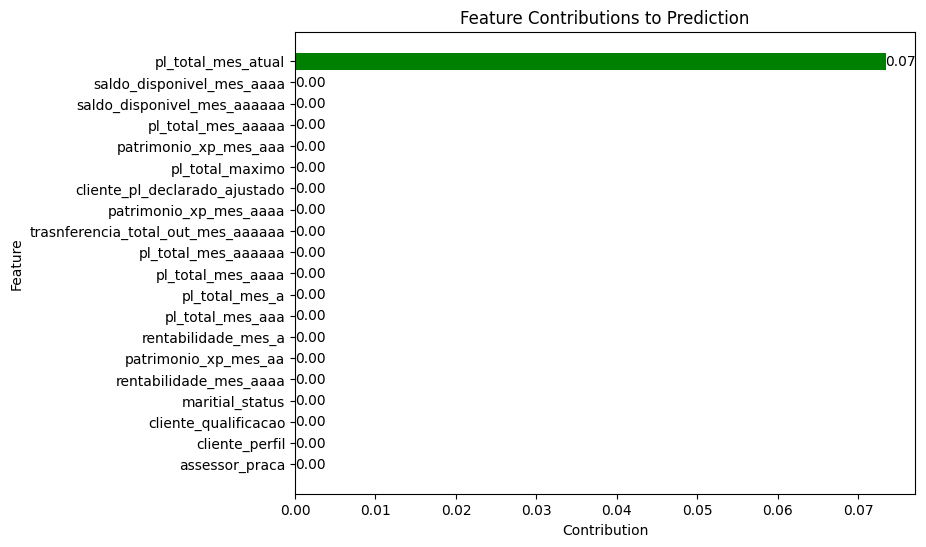

In [108]:
# Choose the user index: from 0 to 12
user_index=1

# And finally choose the model: model_1, mode_2, model_3
feature_importance(model_2, user_index)